# 1. DB 연결

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt


# 2. 서비스 데이터베이스에서 상품정보 수집

In [2]:
query = f"""SELECT
                    p.id
                  , p.uid
                  , p.status AS status
                  , p.price
                  , pd.description
                  , p.flag_used AS used
                  , p.flag_taekpo AS free_shipping
                  , p.flag_exchg AS exchange
                  , p.category_id
                  , p.enc_location
                  , p.enc_latitude
                  , p.enc_longitude
                  , p.name
                  , p.create_date
                  , p.m_time
                  , p.s3_storage
                  , p.keyword AS keywords
                  , c.name AS category_name
                  , IFNULL(pu.register_date, now()) AS update_time
                  , ps.extended_spec
                  , IFNULL(pe.interest, 0) AS view_count
                  , IFNULL(pe.pfavcnt, 0) AS favorite_count
                  , pe.comment_cnt AS comment_count
                  , pe.is_adult AS adult
                  , pe.ptranscnt AS contact_count
                  , IF(cs.is_removed = 0, 1, 0) AS checkout
                  , IFNULL(ub.bizlicense, 0) AS by_bizseller
                  , p.modified_at
                  , ps.updated AS modified_at_ps
                  , cs.modified_at AS modified_at_cs
                  , su.status AS super_up_status
                  , IF(su.status=2 AND su.type = 1, (SELECT sul.enable FROM ad_super_up_lite_group sul WHERE sul.suid = su.suid), IF(su.status=2, 1, 0)) is_display_super_up
                  , IFNULL(suspd.idx, 0)*IFNULL(sus.sus_id, 0)*IFNULL(suspd.on_off, 0) as is_super_up_shop
                  , IFNULL(suspd.on_off, -1) as is_displayable_super_up_shop
                  , IFNULL(es365.product_reported_count, 0) product_reported_count_365
                  , IFNULL(es365.shop_reported_count, 0) shop_reported_count_365
                  , IFNULL(es365.review_reported_count + es365.review_reply_reported_count, 0) review_reported_count_365
                  , IFNULL(es365.comment_reported_count, 0) comment_reported_count_365
                  , IFNULL(es365.group_post_reported_count, 0) group_post_reported_count_365
                  , IFNULL(es90.product_reported_count, 0) product_reported_count_90
                  , IFNULL(es90.shop_reported_count, 0) shop_reported_count_90
                  , IFNULL(es90.review_reported_count + es90.review_reply_reported_count, 0) review_reported_count_90
                  , IFNULL(es90.comment_reported_count, 0) comment_reported_count_90
                  , IFNULL(es90.group_post_reported_count, 0) group_post_reported_count_90
                  , IFNULL(es30.product_reported_count, 0) product_reported_count_30
                  , IFNULL(es30.shop_reported_count, 0) shop_reported_count_30
                  , IFNULL(es30.review_reported_count + es30.review_reply_reported_count, 0) review_reported_count_30
                  , IFNULL(es30.comment_reported_count, 0) comment_reported_count_30
                  , IFNULL(es30.group_post_reported_count, 0) group_post_reported_count_30
                  , outlink.outlink_url
                  , IFNULL(pc.contact_hope, 0) contact
                  , IFNULL(pn.display_on_neighborhood, 0) as neighborhood
FROM
                    product_info p
                    LEFT JOIN product_up pu ON p.id = pu.pid
                    LEFT JOIN product_spec_json ps ON p.id = ps.pid
                    LEFT JOIN product_description pd ON p.id = pd.pid
                    LEFT JOIN product_ext pe ON p.id = pe.pid
                    LEFT JOIN checkout_status cs ON p.id = cs.pid
                    LEFT JOIN user_bizlicense ub ON p.uid = ub.uid
                    LEFT JOIN product_outlink outlink ON p.id = outlink.pid
                    LEFT JOIN product_contact_option pc ON p.id = pc.pid
                    LEFT JOIN ad_super_up su ON p.id = su.pid AND su.status = 2 AND EXISTS (SELECT 1 FROM ad_super_up_point spu WHERE su.suid = spu.suid AND now() BETWEEN start_at AND end_at)
                    LEFT JOIN ad_super_up_shop sus ON p.uid = sus.uid AND now() BETWEEN sus.start_at AND sus.end_at AND sus.status=2
                    LEFT JOIN ad_super_up_shop_products suspd on p.id=suspd.pid and sus.sus_id=suspd.sus_id
                    LEFT JOIN emergency_uniq_stats es30 ON p.uid = es30.uid AND es30.period = 30
                    LEFT JOIN emergency_uniq_stats es90 ON p.uid = es90.uid AND es90.period = 90
                    LEFT JOIN emergency_uniq_stats es365 ON p.uid = es365.uid AND es365.period = 365
                    LEFT JOIN product_neighborhood pn ON p.id = pn.pid
                    LEFT JOIN categories c ON c.category = p.category_id
WHERE p.create_date BETWEEN '2020-05-28 00:00:00' AND '2020-05-31 23:59:59';"""

df = pd.read_sql(query, con=db_slave)

/Users/emilyPark/.pyenv/versions/3.7.5/envs/bun-analytics/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1292, "Truncated incorrect DOUBLE value: 'ALL'")
  result = self._query(query)


In [23]:
product_template = {
  "category": {
    "name": "",
    "level1": "",
    "level2": "",
    "level3": ""
  },
  "createdAt": "",
  "description": "",
  "modifiedAt": "",
  "id": 0,
  "keywords": "",
  "location": {
    "name": "",
    "coords": {
        "lat": 0.0,
        "lon": 0.0
    }
  },
  "m_time": 0,
  "meta": {
    "adult": 0,
    "contact": 0,
    "display": "",
    "exchange": 0,
    "freeShipping": 0,
    "used": 0
  },
  "metrics": {
    "commentCount": 0,
    "contactCount": 0,
    "favoriteCount": 0,
    "viewCount": 0,
    "impressionCount": 0,
    "ctr": 0.0
  },
  "name": "",
  "price": 0,
  "status": 0,
  "updatedAt": "",
  "user": {
    "uid": 0,
    "reportScore": 0.0
  }
}

# 2-1. 클릭 수 수집

In [4]:
query = f"""
SELECT content_id, count(*) FROM bun_log_db.app_event_type_view
WHERE content_id IN (
SELECT CAST(id as varchar) FROM (
SELECT CASE WHEN id ~ '^[0-9]+$' then id else null end as id  FROM service1_quicket.product_info
WHERE create_date BETWEEN '2020-05-28 00:00:00' AND '2020-05-31 23:59:59')) AND YEAR||MONTH||DAY >= '20200528' AND YEAR||MONTH||DAY <= '20200531'
AND user_id != content_owner
GROUP BY content_id;
"""

view_df = pd.read_sql(query, con=bun_analytics)

# 2-2. 노출 수 수집

In [5]:
query = f"""
SELECT content_id, count(*) FROM bun_log_db.app_event_type_impression
WHERE content_id IN (
SELECT CAST(id as varchar) FROM (
SELECT CASE WHEN id ~ '^[0-9]+$' then id else null end as id  FROM service1_quicket.product_info
WHERE create_date BETWEEN '2020-05-28 00:00:00' AND '2020-05-31 23:59:59')) AND YEAR||MONTH||DAY >= '20200528' AND YEAR||MONTH||DAY <= '20200531'
AND user_id != content_owner
GROUP BY content_id;
"""

imp_df = pd.read_sql(query, con=bun_analytics)

In [6]:
imp_dict = imp_df.groupby('content_id')['count'].apply(int).to_dict()
view_dict = view_df.groupby('content_id')['count'].apply(int).to_dict()

# 2-3. 신고 점수 계산

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['comment_reported_count_30', 'comment_reported_count_90', 'comment_reported_count_365']] = scaler.fit_transform(df[['comment_reported_count_30', 'comment_reported_count_90','comment_reported_count_365']].to_numpy())
df[['review_reported_count_30', 'review_reported_count_90', 'review_reported_count_365']] = scaler.fit_transform(df[['review_reported_count_30', 'review_reported_count_90','review_reported_count_365']].to_numpy())
df[['shop_reported_count_30', 'shop_reported_count_90', 'shop_reported_count_365']] = scaler.fit_transform(df[['shop_reported_count_30', 'shop_reported_count_90','shop_reported_count_365']].to_numpy())
df[['product_reported_count_30', 'product_reported_count_90', 'product_reported_count_365']] = scaler.fit_transform(df[['product_reported_count_30', 'product_reported_count_90','product_reported_count_365']].to_numpy())

In [22]:
df['reported_count_30'] = round((df['comment_reported_count_30'] + df['review_reported_count_30'] + df['shop_reported_count_30'] + df['product_reported_count_30']) * 0.6, 6)
df['reported_count_90'] = round((df['comment_reported_count_90'] + df['review_reported_count_90'] + df['shop_reported_count_90'] + df['product_reported_count_90']) * 0.25, 6)
df['reported_count_365'] = round((df['comment_reported_count_365'] + df['review_reported_count_365'] + df['shop_reported_count_365'] + df['product_reported_count_365']) * 0.15, 6)
# df['reported_count_365'] = df['comment_reported_count_365'] + df['review_reported_count_365'] + df['shop_reported_count_365'] + df['product_reported_count_365']

df['report_score'] = round(df['reported_count_30'] + df['reported_count_90'] + df['reported_count_365'], 6)
# df['report_score'] = df['reported_count_365']

In [13]:
df.head()

,id,uid,status,price,description,used,free_shipping,exchange,category_id,enc_location,...,product_reported_count_30,shop_reported_count_30,review_reported_count_30,comment_reported_count_30,group_post_reported_count_30,outlink_url,contact,neighborhood,reported_count_365,report_score
0,125612864,2203726,3,80000,,13,0,0,210217001,0:oAR+IjBzWBVix1eWY7l+Ae4H3hOMw9lQRJC1sC7b1ZM=...,...,1,0,0,0,0,None,0,1,1,1
1,125593152,1266797,3,30000,상태양호\n정품\n남녀공용 스몰,13,0,0,310010040,0:SKJGIcuSAFej9OrbRa5Y7k9xinSIcfvBbdCyvxbBgiIV...,...,0,0,0,0,0,None,0,1,2,2
2,125586624,6343625,0,52000,구매전 상세 설명 미숙지로 인한 책임은 지지않으니 꼭 숙지 부탁드립니다\n안녕하세요...,2,0,0,310010999,0:Unw+gkDxFP/UM2J8Y/CJa9pFl/DwjDjUldUVVR6et44=...,...,0,0,0,0,0,None,0,1,4,4
3,125588224,4057494,0,20000,"착용 3회, 하자 x, 실사 번톡\n다림질 해서 보내드려요 !",13,0,0,310020010,0:d4v6lNNo3Jr39YiLJvh72KlLCmRoMi/JZoZwqdYz5a7j...,...,2,0,0,0,0,None,0,1,2,2
4,125583808,4072794,0,39000,팜엔젤스 나비 티셔츠\n\n블랙 화이트 \nFREE(-110) \n\n어깨 56cm...,2,1,0,310020020,,...,0,0,0,0,0,None,0,0,0,0


# 3. ES 벌크 데이터로 변환후 삽입

In [18]:
from datetime import datetime
from time import sleep
import requests
import json

headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

In [19]:
def make_header(index, _id):
    return '{"index": {"_index": "%s", "_id": "%s"}}\n' % (index, _id)

In [24]:
es_bulk_data = str()
index_name = "product"
for idx, row in df.iterrows():
    
    product_template['category']['name'] = row['category_name']
    product_template['category']['level1'] = str(row['category_id'])[:3]
    product_template['category']['level2'] = str(row['category_id'])[3:6]
    product_template['category']['level3'] = str(row['category_id'])[-3:]
    
    product_template['createdAt'] = datetime.strftime(row['create_date'], '%Y%m%d%H%M%S')
    product_template['description'] = row['description']
    product_template['modifiedAt'] = datetime.strftime(row['modified_at'], '%Y%m%d%H%M%S')
    product_template['id'] = row['id']
    product_template['keywords'] = row['keywords']
        
    product_template['m_time'] = row['m_time']

    product_template['meta']['adult'] = row['adult']
    product_template['meta']['contact'] = row['contact']
    product_template['meta']['display'] = "None"
    product_template['meta']['exchange'] = row['exchange']
    product_template['meta']['freeShipping'] = row['free_shipping']
    product_template['meta']['used'] = row['used']
    
    product_template['metrics']['commentCount'] = row['comment_count']
    product_template['metrics']['contactCount'] = row['contact_count']
    product_template['metrics']['favoriteCount'] = row['favorite_count']
    view_count = view_dict.get(str(row['id']), 0)
    imp_count = imp_dict.get(str(row['id']), 0)
    if imp_count > 0:
        ctr = round(view_count / imp_count, 4)
    else:
        ctr = 0.0000
    product_template['metrics']['viewCount'] = view_count
    product_template['metrics']['impressionCount'] = imp_count

    product_template['metrics']['ctr'] = ctr * 100
    
    product_template['name'] = row['name']
    product_template['price'] = row['price']
    product_template['status'] = row['status']
    product_template['updatedAt'] = datetime.strftime(row['update_time'], '%Y%m%d%H%M%S')
    
    product_template['user']['uid'] = row['uid']
    product_template['user']['reportScore'] = row['report_score']
    
    query_headers = make_header(index_name, row['id'])
    es_bulk_data += query_headers + json.dumps(product_template) + "\n"
    
    if idx % 1000 == 0:
        requests.post(url="http://127.0.0.1:9200/product/_bulk", 
                      data=es_bulk_data, 
                      headers=headers)
        es_bulk_data = str()
        sleep(10)

In [46]:
view_df = {}
ids = []
view_cnt = []
for i in view_dict.keys():
    ids.append(i)
    view_cnt.append(view_dict.get(i))
view_df['id'] = ids
view_df['view_cnt'] = view_cnt
view_df = pd.DataFrame.from_dict(view_df)

In [47]:
imp_df = {}
ids = []
imp_cnt = []
for i in imp_dict.keys():
    ids.append(i)
    imp_cnt.append(imp_dict.get(i))
imp_df['id'] = ids
imp_df['imp_cnt'] = imp_cnt
imp_df = pd.DataFrame.from_dict(imp_df)

In [48]:
ctr = pd.merge(view_df, imp_df, on='id', how='outer')
ctr.head()

,id,view_cnt,imp_cnt
0,125583500,16.0,555.0
1,125583501,6.0,77.0
2,125583502,1.0,8.0
3,125583503,2.0,46.0
4,125583504,10.0,1286.0


In [49]:
c = []
for i in range(len(ctr)):
    row = ctr.iloc[i]
    if row['imp_cnt'] > 0:
        c.append(round(row['view_cnt']/row['imp_cnt'], 4))
    else:
        c.append(0)
ctr['ctr'] = c

In [50]:
ctr = ctr.fillna(0)

In [51]:
df['id'] = df['id'].astype(str)
ctr['id'] = ctr['id'].astype(str)
data = pd.merge(df, ctr, on='id')

In [52]:
data

,id,uid,status,price,description,used,free_shipping,exchange,category_id,enc_location,...,outlink_url,contact,neighborhood,reported_count_30,reported_count_90,reported_count_365,report_score,view_cnt,imp_cnt,ctr
0,125593152,1266797,3,30000,상태양호\n정품\n남녀공용 스몰,13,0,0,310010040,0:SKJGIcuSAFej9OrbRa5Y7k9xinSIcfvBbdCyvxbBgiIV...,...,None,0,1,0.000000,0.013088,0.007097,0.020185,104.0,159.0,0.6541
1,125586624,6343625,0,52000,구매전 상세 설명 미숙지로 인한 책임은 지지않으니 꼭 숙지 부탁드립니다\n안녕하세요...,2,0,0,310010999,0:Unw+gkDxFP/UM2J8Y/CJa9pFl/DwjDjUldUVVR6et44=...,...,None,0,1,0.000000,0.001724,0.004174,0.005898,1.0,49.0,0.0204
2,125588224,4057494,0,22000,착용 3회\n다림질 해서 보내드려요 !,13,0,0,310020010,0:n/+/zWuj0xeb+X5xwcqslCbDL8N2N9ksUvEyRG6OKzFD...,...,None,0,1,0.000000,0.000000,0.000000,0.000000,62.0,1177.0,0.0527
3,125583808,4072794,0,39000,팜엔젤스 나비 티셔츠\n\n블랙 화이트 \nFREE(-110) \n\n어깨 56cm...,2,1,0,310020020,,...,None,0,0,0.000000,0.000000,0.000000,0.000000,0.0,69.0,0.0000
4,125587072,6437595,2,10000,피버타임 마넌\n하라주쿠 오처넌에 쿨거원함,13,0,0,310020020,0:deDpiqntcg8Vbxow26fCBoK1rEzMD4t+AfUwEy0d/maG...,...,None,0,1,0.168240,0.033223,0.015827,0.217290,8.0,63.0,0.1270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275104,125855807,1077322,2,20000,카시트가방이구요 안전밸트로 고정가능합니다\n40 34 26 사이즈 이구요 깨끗합니다,13,0,0,999,0:ZddapPp6/cFf2c0JkTTcJBYKbCOGs791rgFdlu3ZLwrS...,...,None,0,1,0.000000,0.000000,0.000000,0.000000,0.0,51.0,0.0000
275105,125858623,11532479,0,15000,관심 있으시는분들 연락주세요 \n충전 잘되요~,13,0,0,999,,...,None,0,0,0.000000,0.000000,0.000000,0.000000,1.0,15.0,0.0667
275106,125859903,11242643,0,280000,년대가 오래된\n 가죽물통\n\n년대가 어마어마하게\n오래된 가죽물통 입니다\n(...,13,1,0,999,0:Tlkh5iVcXmjzQUIoZXKNmZt5ONVrOU3TIfLsjgE9rIot...,...,None,0,1,0.000000,0.000000,0.000000,0.000000,2.0,9.0,0.2222
275107,125860863,7616284,0,1000,정시각형 투명인스 총 6도안 각각 1매씩 총 6장에 좌측 모아둔 돔송과 스티커류 랜...,2,1,0,999,0:prCQrAk6+mVfZfRViRoE+H1gOfM0QTFofYkIfc/v9NVk...,...,None,0,1,0.156994,0.030562,0.015435,0.202991,7.0,133.0,0.0526


In [56]:
level1 = []
for i in data['category_id']:
    level1.append(i[:3])
data['category_level1'] = level1

In [57]:
data.columns

Index(['id', 'uid', 'status', 'price', 'description', 'used', 'free_shipping',
       'exchange', 'category_id', 'enc_location', 'enc_latitude',
       'enc_longitude', 'name', 'create_date', 'm_time', 's3_storage',
       'keywords', 'category_name', 'update_time', 'extended_spec',
       'view_count', 'favorite_count', 'comment_count', 'adult',
       'contact_count', 'checkout', 'by_bizseller', 'modified_at',
       'modified_at_ps', 'modified_at_cs', 'super_up_status',
       'is_display_super_up', 'is_super_up_shop',
       'is_displayable_super_up_shop', 'product_reported_count_365',
       'shop_reported_count_365', 'review_reported_count_365',
       'comment_reported_count_365', 'group_post_reported_count_365',
       'product_reported_count_90', 'shop_reported_count_90',
       'review_reported_count_90', 'comment_reported_count_90',
       'group_post_reported_count_90', 'product_reported_count_30',
       'shop_reported_count_30', 'review_reported_count_30',
       'comment

In [60]:
data = data[['id', 'name', 'price', 'status', 'exchange', 'contact', 'free_shipping', 'used', 'adult', 'uid', 'report_score', 'keywords', 'update_time', 'category_level1', 'comment_count', 'view_cnt', 'imp_cnt', 'ctr', 'favorite_count', 'contact_count']]

In [2]:
# data.to_csv('normal_products.csv', index=False)
data = pd.read_csv('normal_products.csv')

In [4]:
data.head()

,id,name,price,status,exchange,contact,free_shipping,used,adult,uid,report_score,keywords,update_time,category_level1,comment_count,view_cnt,imp_cnt,ctr,favorite_count,contact_count
0,125593152,꼼데 보더티,30000,3,0,0,0,13,0,1266797,0.020185,55.66,2020-05-28 05:23:05.474000,310,0,104.0,159.0,0.6541,7,0
1,125586624,[MONCLER] 잔단롱티,52000,0,0,0,0,2,0,6343625,0.005898,"몽클레어잔단롱티,롱티,몽클레어,잔단롱티,몽클레어티셔츠",2020-05-28 00:50:37.775000,310,0,1.0,49.0,0.0204,0,0
2,125588224,오도어메이드 베이직 크롭티 핑크,22000,0,0,0,0,13,0,4057494,0.000000,"오도어,스푸닝,보헤미안서울,쓰리타임즈,포에버21",2020-06-08 02:23:47.034204,310,1,62.0,1177.0,0.0527,7,0
3,125583808,❤️팜엔젤스 나비 반팔티❤️,39000,0,0,0,1,2,0,4072794,0.000000,"팜엔젤스반팔티,팜엔젤스반팔티셔츠,팜엔젤스반팔,레플리카",2020-05-28 00:05:00.047000,310,0,0.0,69.0,0.0000,0,0
4,125587072,브랜드 반팔,10000,2,0,0,0,13,0,6437595,0.217290,"피버타임,여자반팔,사이즈프리,하라주쿠,남녀공용",2020-05-28 00:58:30.642000,310,0,8.0,63.0,0.1270,0,0


In [11]:
data.columns

Index(['id', 'name', 'price', 'status', 'exchange', 'contact', 'free_shipping',
       'used', 'adult', 'uid', 'report_score', 'keywords', 'update_time',
       'category_level1', 'comment_count', 'view_cnt', 'imp_cnt', 'ctr',
       'favorite_count', 'contact_count'],
      dtype='object')

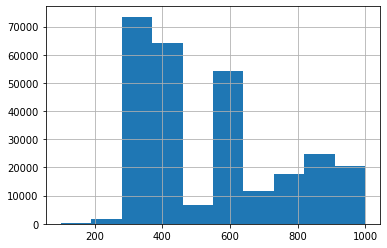

In [12]:
data['category_level1'].hist()

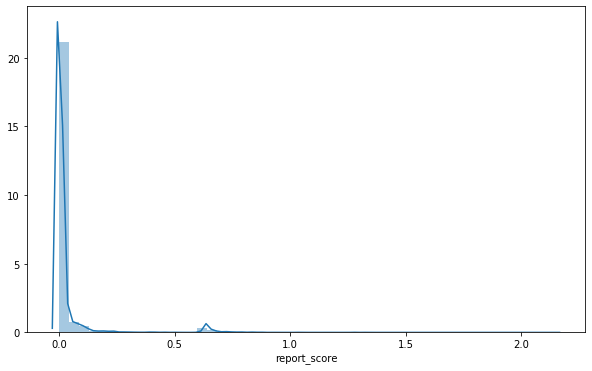

In [69]:
# import seaborn as sns
# import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.distplot(data['report_score'])

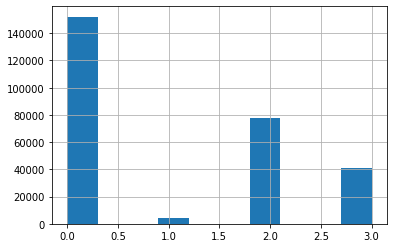

In [5]:
data['status'].hist()

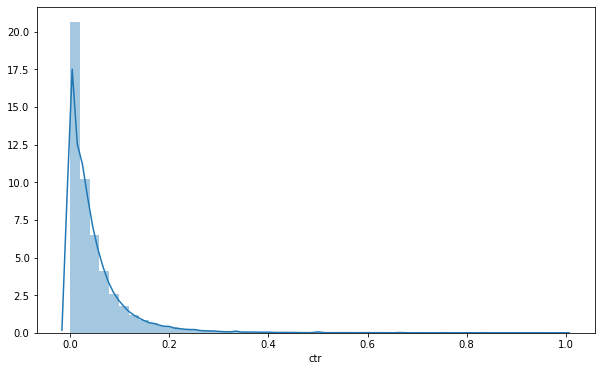

In [13]:
plt.figure(figsize=(10,6))
sns.distplot(data[data['ctr'] < 1]['ctr'])

In [10]:
weird = data[data['ctr'] >= 1]
weird[['view_cnt', 'imp_cnt', 'ctr']]

,view_cnt,imp_cnt,ctr
244,47.0,41.0,1.1463
476,29.0,12.0,2.4167
1225,12.0,6.0,2.0000
2966,1.0,1.0,1.0000
3572,111.0,82.0,1.3537
...,...,...,...
274256,1.0,1.0,1.0000
274585,1.0,1.0,1.0000
274607,14.0,6.0,2.3333
274995,2.0,1.0,2.0000


In [14]:
weird.to_csv('weird.csv', index=False)